In [332]:
import os
from tkinter import *
from tkinter import filedialog
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
#import pandas as pd

In [333]:
def tag_match():                                                                # for mapping of pos_tag
    tag_map = defaultdict(lambda: 'n')
    tag_map['J'] = 'a'
    tag_map['V'] = 'v'
    tag_map['R'] = 'r'
    return tag_map


In [334]:
lemmatizer = WordNetLemmatizer()
def pre_process(words):
    filtered_words = []
    tag_map = tag_match()
    stop_words = set(stopwords.words('english'))
    dic = [word.lower() for word in words]
    dic = [''.join(w for w in string if w.isalpha()) for string in dic] #isalnum()
    dic = [w for w in dic if w not in stop_words]
    dic = [word for word in dic if word]
    for token, tag in pos_tag(dic):
        filtered_words.append(lemmatizer.lemmatize(token, tag_map[tag[0]]))
    for word in filtered_words:
        if len(word) == 1:
            filtered_words.remove(word)
    return filtered_words

In [335]:
def read_doc(file):
    f = open(file, 'r')
    doc_words = (f.read().split())
    filtered_words = pre_process(doc_words)
    #print(filtered_words)
    #insertInBOW(filtered_words)
    str_ = ' '.join(filtered_words)  
    f.close()
    return str_

In [336]:
def reading_dataset(cat_list, path, cat):
    doc_id = 0
    docsPointer = [] # where ecah category's documents end in document lists array (doc_list)
    doc_list = [] 
    category = []
    cat_names = cat_list
    i = 0
    for name in cat_names:
        dirr = f'{path}/{name}/'
        files = os.listdir(dirr)
        filesDirectories = [dirr + file for file in files]

        for file in filesDirectories:
            doc_words = read_doc(file)
            doc_list.append(doc_words)
            category.append(i)
            #print(doc_list)
            #print(str_,i)
            doc_id += 1
        i=i+1
        docsPointer.append(doc_id-1)
        print("read ",doc_id, " documents")
    print_noOfDoc(docsPointer,cat)
    return doc_list,category

In [337]:
def print_noOfDoc(docsPointer,cat):
    noOfDoc= []
    #Printing no of documents in each category
    for i in range(len(docsPointer)):
        if i==0:
            noOfDoc.append(docsPointer[i]+1)
        else:
            noOfDoc.append(docsPointer[i]-docsPointer[i-1])
    print(f"No of docs in each category of {cat} dataset",noOfDoc)


In [323]:
#len(doc_list)
def purify_with_clustering(doc_list,category,cat_names):
    
    #Vectorizing
    vectorizer = TfidfVectorizer()
    vectorizer.fit(doc_list)
    clus_vec = vectorizer.transform(doc_list).toarray()
    #print(vec)
    #len(clus_vec)
    #len(category)
    
    #Clustering
    km = KMeans(n_clusters =5)
    km.fit(clus_vec)
    clus_labels = km.labels_
    
    #Assigning clusters majority vote in a cluster
    pointer = 0
    count = [0,0,0,0,0]
    for j in range(len(count)):
        if j != 0:
            pointer = docsPointer[j-1]+1
            #print(pointer)

        for i in range(pointer,docsPointer[j]):
            if clus_labels[i] == 0:
                count[0] +=1
            elif clus_labels[i] == 1:
                count[1] +=1
            elif clus_labels[i] == 2:
                count[2] +=1
            elif clus_labels[i] == 3:
                count[3] +=1
            elif clus_labels[i] == 4:
                count[4] +=1
            else:
                print("Error")
        print("number of docs of ", cat_names[j], "in corresponding clusters are: ", count)
        cat_clus = count.index(max(count)) # cat_clus is the category belong to which cluster
        print(cat_names[j],"'s cluster belongs to cluster",cat_clus)
        count = [0,0,0,0,0]
        
        #deleting documents which does not belong to its cluster
        for i in range(pointer,docsPointer[j]):
            if clus_labels[i] != cat_clus:
                doc = doc_list[i]
                cat = category[i]
                doc_list.remove(doc)
                category.remove(cat)
                #print("Doc:",doc_list[i], "\n its category:", category[i])
                #print(i)

In [324]:
def train(doc_list, category):
    vectorizer = CountVectorizer(ngram_range=(1,2), max_features=30000)
    #features = vectorizer.get_feature_names()
    #len(features)
    #print(features)
    vec_train = vectorizer.fit_transform(doc_list).toarray()
    #print(vec_train)
    #len(vec_train)
    X_train, y_train = vec_train, category
    classifier = MultinomialNB()
    trained = classifier.fit(X_train, y_train)
    return trained,vectorizer

In [325]:
def predict(trained,vectorizer,docs):
    #newDoc = read_doc(file)
    #print(newDoc)
    vec_test = vectorizer.transform(docs)
    X_test = vec_test
    #print(X_test.shape)
    y_pred = trained.predict(X_test)
    #print("prediction is: ", y_pred)
    #accuracy_score(y_test,y_pred)
    return y_pred

In [339]:
print("Reading main dataset...")
cat_list_main = ['business','entertainment','politics','sport','tech']
path_main = 'C:/Users/user/Desktop/bbc'
doc_list_main, category_main = [],[]
doc_list_main, category_main = reading_dataset(cat_list_main,path_main, "Main")
#purify_with_clustering(doc_list_main,category_main,cat_list_main)

Reading main dataset...
read  510  documents
read  896  documents
read  1313  documents
read  1824  documents
read  2225  documents
No of docs in each category of Main dataset [510, 386, 417, 511, 401]


In [340]:
print("Training main dataset...")
trained_main,vec_main = train(doc_list_main, category_main)
print("Done")

Training main dataset...
Done


In [341]:
print("Reading sports dataset...")
cat_list_sports = ['athletics','cricket','football','rugby','tennis']
path_sports = 'C:/Users/user/Desktop/bbcsport'
doc_list_sports, category_sports = [],[]
doc_list_sports, category_sports = reading_dataset(cat_list_sports,path_sports, "Sports")
#purify_with_clustering(doc_list_main,category_main)

Reading sports dataset...
read  101  documents
read  225  documents
read  490  documents
read  637  documents
read  737  documents
No of docs in each category of Sports dataset [101, 124, 265, 147, 100]


In [329]:
print("Training sports dataset...")
trained_sports,vec_sports = train(doc_list_sports, category_sports)
print("Done")

Training sports dataset...
Done


In [330]:
def pred_doc(docs):
    #print("Predicting the main category...")
    mainPred = predict(trained_main,vec_main,docs)[0]
    output = f"The document belongs to {cat_list_main[mainPred]}."
    if mainPred==3:
        sportPred = predict(trained_sports,vec_sports,docs)[0]
        out_other = f" And in {cat_list_main[mainPred]} category it belongs to {cat_list_sports[sportPred]}"
        output = output + out_other
    return output

In [ ]:
def open_doc():
    docs = []
    doc_file = filedialog.askopenfilename(initialdir='C:/Users/user/Desktop', title= "open document", filetypes=(("Text Files", "*.txt"),))
    doc_file = open(doc_file, 'r') 
    s_list = (doc_file.read().split())
    newDoc = ' '.join(s_list)
    doc_file.close()
    docs.append(newDoc)
    Result_Field['text'] = pred_doc(docs)
    
root = Tk()
root.title('CLASSIFICATION OF NEWS DOCUMENTS')

master = LabelFrame(root, bg='grey', padx=40, pady=40, width=800, height=800)
master.pack()

title = Label(master, text="CLASSIFICATION SYSTEM", font="Times 10 bold")
title.pack(pady=20)

Query_Frame = LabelFrame(master, text="PLACE YOUR DOCUMENT", font="Times 10 bold", bg='grey')
Query_Frame.pack(pady=20)

#Query_Field = Entry(Query_Frame, width=12000, bg="white", fg='black')
#Query_Field.pack(pady=20)
open_button = Button(master, text="Open your document", command=open_doc)
open_button.pack(pady=20)
#b = Button(Query_Frame, text="Enter", command=lambda: entered(Query_Field.get()))
#b.pack()

output = LabelFrame(master, text="category", font="Times 10 bold", width=12000, height=50)
output.pack(pady=20)

Result_Field = Label(output, text="", width=200, font="Times 10 bold")
Result_Field.pack()
output.pack_propagate(0)
root.mainloop()

Text(0, 0.5, 'Accuracy')

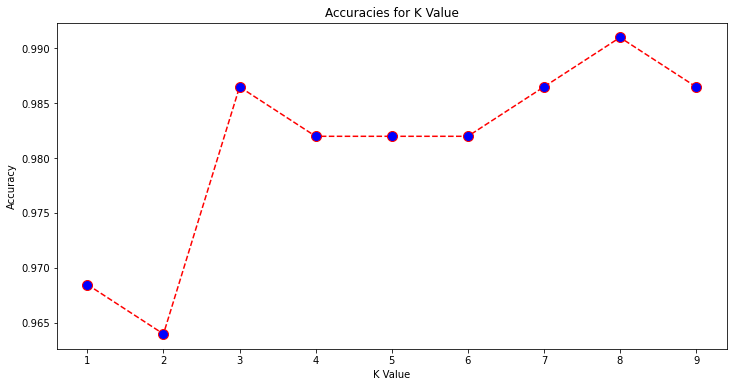

In [213]:
'''plt.figure(figsize=(12, 6))
plt.plot(range(1, 10), accuracies, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Accuracies for K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')'''